# 📈 Многомерное прогнозирование временных рядов с DARTS

Этот блокнот реализует многомерное прогнозирование финансовых временных рядов с использованием библиотеки DARTS.

## 🎯 Основные особенности

- **Многомерные данные**: используем данные из папки `/data/multivariate_series/`
- **Поэтапные признаки**: различные этапы добавления фичей согласно progressive feature analysis
- **Walk-forward прогнозирование**: честное тестирование с расширяющимся окном
- **Горизонт прогноза**: 10 точек (вместо 100 в univariate версии)
- **Модели**: RandomForest, XGBModel, CatBoostModel, RegressionModel
- **Метрики**: RMSE, MAPE, DA (Directional Accuracy)

## 📊 Структура этапов признаков

1. **Этап 1**: Только цены закрытия (close)
2. **Этап 2**: + Аномалии (anomaly)
3. **Этап 3**: + Новостные настроения (weighted_score_with_decay)
4. **Этап 4**: Пропущен (как в оригинале)
5. **Этап 5**: + Базовые OHLCV признаки
6. **Этап 6**: + Технические индикаторы
7. **Этап 7**: + Статистические признаки (TSFresh)

In [ ]:
# Импорты
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import os
from pathlib import Path
from typing import List, Dict, Tuple, Optional
warnings.filterwarnings('ignore')

# DARTS библиотеки
from darts import TimeSeries
from darts.models import (
    RandomForest,
    XGBModel,
    CatBoostModel,
    RegressionModel
)
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, rmse, mae

# Библиотеки для анализа
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Настройка отображения
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12

print("Библиотеки загружены успешно")

In [39]:
# Конфигурация
DATA_PATH = "../../data/multivariate_series/"
OUTPUT_PATH = "results/multivariate_darts/"
FORECAST_HORIZON = 10  # Прогнозируем на 10 точек (вместо 100)
TEST_SIZE = 11  # Размер тестового набора

# Создаем папку для результатов
Path(OUTPUT_PATH).mkdir(parents=True, exist_ok=True)

# Список тикеров
TICKERS = ['AFLT', 'LKOH', 'MOEX', 'NVTK', 'PIKK', 'SBER', 'VKCO', 'VTBR', 'X5', 'YDEX']

# Названия этапов для отображения
STAGE_NAMES = {
    1: "Базовая цена (close)",
    2: "Цена + аномалии",
    3: "Цена + аномалии + новости",
    4: "Всё выше + OHLCV",
    5: "Всё выше + технические индикаторы",
    6: "Всё выше + статистические признаки"
}

print(f"Настройки:")
print(f"- Путь к данным: {DATA_PATH}")
print(f"- Горизонт прогноза: {FORECAST_HORIZON}")
print(f"- Размер тест. данных: {TEST_SIZE}")
print(f"- Количество тикеров: {len(TICKERS)}")
print(f"- Папка результатов: {OUTPUT_PATH}")

Настройки:
- Путь к данным: ../../data/multivariate_series/
- Горизонт прогноза: 10
- Размер тест. данных: 11
- Количество тикеров: 10
- Папка результатов: results/multivariate_darts/


In [46]:
# Функции для подготовки признаков по этапам
def prepare_features_for_stage(df: pd.DataFrame, stage: int) -> List[str]:
    """
    Подготавливает список признаков для определенного этапа
    
    Args:
        df: DataFrame с данными
        stage: номер этапа (1-7)
    
    Returns:
        List[str]: список названий колонок для данного этапа
    """
    available_features = set(df.columns)
    
    # Этап 1: Только цена закрытия
    if stage == 1:
        return ['close'] if 'close' in available_features else []
    
    # Этап 2: Цена + аномалии
    elif stage == 2:
        features = ['close']
        if 'anomaly' in available_features:
            features.append('anomaly')
        return [f for f in features if f in available_features]
    
    # Этап 3: Цена + аномалии + новости
    elif stage == 3:
        features = ['close']
        if 'anomaly' in available_features:
            features.append('anomaly')
        if 'weighted_score_with_decay' in available_features:
            features.append('weighted_score_with_decay')
        return [f for f in features if f in available_features]
    
    # Этап 4: Всё выше + OHLCV
    elif stage == 4:
        features = ['close']
        if 'anomaly' in available_features:
            features.append('anomaly')
        if 'weighted_score_with_decay' in available_features:
            features.append('weighted_score_with_decay')
        
        # Добавляем OHLCV
        ohlcv_features = ['open', 'high', 'low', 'volume']
        for feat in ohlcv_features:
            if feat in available_features:
                features.append(feat)
        
        return [f for f in features if f in available_features]
    
    # Этап 5: Всё выше + технические индикаторы
    elif stage == 5:
        features = ['close']
        if 'anomaly' in available_features:
            features.append('anomaly')
        if 'weighted_score_with_decay' in available_features:
            features.append('weighted_score_with_decay')
        
        # OHLCV
        ohlcv_features = ['open', 'high', 'low', 'volume']
        for feat in ohlcv_features:
            if feat in available_features:
                features.append(feat)
        
        # Технические индикаторы
        tech_features = ['EMA_14', 'RSI_14', 'MACD', 'return', 'ATR_14', 'VWAP']
        for feat in tech_features:
            if feat in available_features:
                features.append(feat)
        
        return [f for f in features if f in available_features]
    
    # Этап 6: Всё выше + статистические признаки
    elif stage == 6:
        features = ['close']
        if 'anomaly' in available_features:
            features.append('anomaly')
        if 'weighted_score_with_decay' in available_features:
            features.append('weighted_score_with_decay')
        
        # OHLCV
        ohlcv_features = ['open', 'high', 'low', 'volume']
        for feat in ohlcv_features:
            if feat in available_features:
                features.append(feat)
        
        # Технические индикаторы
        tech_features = ['EMA_14', 'RSI_14', 'MACD', 'return', 'ATR_14', 'VWAP']
        for feat in tech_features:
            if feat in available_features:
                features.append(feat)
        
        # Статистические признаки (выборочно TSFresh)
        tsfresh_stats = [
            'value__mean',
            'value__maximum',
            'value__minimum',
            'value__standard_deviation',
            'value__partial_autocorrelation__lag_3',
            'value__autocorrelation__lag_5',
            'value__longest_strike_above_mean'
        ]
        for feat in tsfresh_stats:
            if feat in available_features:
                features.append(feat)
        
        return [f for f in features if f in available_features]
    
    else:
        return ['close'] if 'close' in available_features else []

print("Функции для подготовки признаков созданы")

Функции для подготовки признаков созданы


In [4]:
# Вспомогательные функции для оценки
def calculate_directional_accuracy(actual: np.ndarray, predicted: np.ndarray) -> float:
    """Вычисляет точность направления (DA)"""
    if len(actual) < 2 or len(predicted) < 2:
        return 0.0
    
    actual_direction = np.diff(actual) > 0
    predicted_direction = np.diff(predicted) > 0
    
    return np.mean(actual_direction == predicted_direction) * 100

def load_ticker_data(ticker: str) -> Optional[pd.DataFrame]:
    """Загружает данные для тикера"""
    file_path = f"{DATA_PATH}{ticker}_multivariate.csv"
    
    if not os.path.exists(file_path):
        print(f"⚠️ Файл не найден: {file_path}")
        return None
    
    try:
        df = pd.read_csv(file_path)
        
        # Проверяем наличие timestamp колонки
        if 'timestamp' in df.columns:
            df['timestamp'] = pd.to_datetime(df['timestamp'])
            df = df.sort_values('timestamp').reset_index(drop=True)
        else:
            # Создаем искусственный индекс времени
            df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='D')
        
        print(f"✅ Загружен {ticker}: {len(df)} записей, {len(df.columns)} колонок")
        return df
        
    except Exception as e:
        print(f"❌ Ошибка загрузки {ticker}: {e}")
        return None

print("Вспомогательные функции созданы")

Вспомогательные функции созданы


In [85]:
# Основная функция для оценки моделей
def evaluate_model_on_ticker(df: pd.DataFrame, ticker: str, stage: int, model_name: str) -> Optional[Dict]:
    """
    Обучает и оценивает модель на данных тикера для определенного этапа
    
    Args:
        df: DataFrame с данными тикера
        ticker: название тикера
        stage: номер этапа
        model_name: название модели ('RandomForest', 'XGBModel', 'CatBoostModel', 'RegressionModel')
        
    Returns:
        Dict с результатами или None при ошибке
    """
    
    #try:
        # Подготавливаем признаки для этапа
    feature_columns = prepare_features_for_stage(df, stage)
    
    if len(feature_columns) == 0:
        print(f"  ⚠️ Нет доступных признаков для {ticker} на этапе {stage}")
        return None
    
    # Проверяем наличие всех колонок
    available_features = [col for col in feature_columns if col in df.columns]
    
    if len(available_features) == 0:
        print(f"  ⚠️ Нет доступных признаков для {ticker} на этапе {stage}")
        return None
    
    # Удаляем строки с NaN в выбранных признаках
    df_clean = df[available_features].dropna()
    
    if len(df_clean) < TEST_SIZE + 20:  # Минимум данных для обучения
        print(f"  ⚠️ Недостаточно данных для {ticker} на этапе {stage}")
        return None
    
    # Подготавливаем данные для DARTS
    target_col = 'close'
    
    if stage == 1:
        # Univariate модель
        ts = TimeSeries.from_dataframe(df_clean, time_col=None, value_cols='close')
        
        # Walk-forward предсказание с extending window
        predictions = []
        current_ts = ts[:-TEST_SIZE]  # Начальное обучающее окно

        t1 = time.time()
        for i in range(FORECAST_HORIZON):
            # Создаем модель
            if model_name == 'RandomForest':
                model = RandomForest(lags=14, random_state=42)
            elif model_name == 'XGBModel':
                model = XGBModel(lags=14, random_state=42)
            elif model_name == 'CatBoostModel':
                model = CatBoostModel(lags=14, random_state=42, verbose=False)
            else:  # RegressionModel
                model = RegressionModel(lags=14, model=RandomForestRegressor(random_state=42))
            
            # Обучаем модель на текущем окне
            model.fit(current_ts)
            
            # Делаем прогноз на 1 шаг вперед
            pred = model.predict(n=1)
            y_pred = pred.values().flatten()[0]
            predictions.append(y_pred)
            
            # Добавляем реальное значение в окно для следующей итерации
            next_time = ts.time_index[len(current_ts)]
            y_true = ts.values()[len(current_ts)][0]
            s = pd.Series([y_true], index=[next_time])
            actual_ts = TimeSeries.from_series(
                s,
                fill_missing_dates=False,
                freq=ts.freq
            )
            current_ts = current_ts.append(actual_ts)
        f_time = (time.time() - t1) / FORECAST_HORIZON
    
    else:
        # Multivariate модель
        past_covariates_cols = [col for col in available_features if col != target_col]
        
        if len(past_covariates_cols) == 0:
            # Fallback к univariate
            ts = TimeSeries.from_dataframe(df_clean, time_col=None, value_cols=target_col)
            
            predictions = []
            current_ts = ts[:-TEST_SIZE]

            t1 = time.time()
            for i in range(FORECAST_HORIZON):
                if model_name == 'RandomForest':
                    model = RandomForest(lags=14, random_state=42)
                elif model_name == 'XGBModel':
                    model = XGBModel(lags=14, random_state=42)
                elif model_name == 'CatBoostModel':
                    model = CatBoostModel(lags=14, random_state=42, verbose=False)
                else:
                    model = RegressionModel(lags=14, model=RandomForestRegressor(random_state=42))
                
                model.fit(current_ts)
                pred = model.predict(n=1)
                y_pred = pred.values().flatten()[0]
                predictions.append(y_pred)
                
                next_time = ts.time_index[len(current_ts)]
                y_true = ts.values()[len(current_ts)][0]
                s = pd.Series([y_true], index=[next_time])
                actual_ts = TimeSeries.from_series(
                    s, fill_missing_dates=False, freq=ts.freq
                )
                current_ts = current_ts.append(actual_ts)
            f_time = (time.time() - t1) / FORECAST_HORIZON
            
        else:
            # Полноценная multivariate модель
            target_ts = TimeSeries.from_dataframe(df_clean, time_col=None, value_cols=target_col)
            past_covariates_ts = TimeSeries.from_dataframe(df_clean, time_col=None, value_cols=past_covariates_cols)

            ts = target_ts
            
            predictions = []
            current_target = target_ts[:-TEST_SIZE]
            current_covariates = past_covariates_ts[:-TEST_SIZE]

            t1 = time.time()
            for i in range(FORECAST_HORIZON):
                # Создаем модель
                if model_name == 'RandomForest':
                    model = RandomForest(
                        lags=14, 
                        lags_past_covariates=7, 
                        random_state=42
                    )
                elif model_name == 'XGBModel':
                    model = XGBModel(
                        lags=14, 
                        lags_past_covariates=7, 
                        random_state=42
                    )
                elif model_name == 'CatBoostModel':
                    model = CatBoostModel(
                        lags=14, 
                        lags_past_covariates=7, 
                        random_state=42, 
                        verbose=False
                    )
                else:  # RegressionModel
                    model = RegressionModel(
                        lags=14, 
                        lags_past_covariates=7,
                        model=RandomForestRegressor(random_state=42)
                    )
                
                # Обучаем модель
                model.fit(
                    series=current_target,
                    past_covariates=current_covariates
                )
                
                # Прогноз
                pred = model.predict(
                    n=1,
                    past_covariates=current_covariates
                )
                y_pred = pred.values().flatten()[0]
                predictions.append(y_pred)
                
                # Добавляем реальные значения для следующей итерации
                next_t = target_ts.time_index[len(current_target)]
                y_true = target_ts.values()[len(current_target)][0]
                s_y = pd.Series([y_true], index=[next_t])
                actual_y_ts = TimeSeries.from_series(
                    s_y, fill_missing_dates=False, freq=target_ts.freq
                )
                current_target = current_target.append(actual_y_ts)
                
                # Добавляем реальные ковариаты
                x_true = past_covariates_ts.values()[len(current_covariates)].flatten()
                df_x = pd.DataFrame([x_true], index=[next_t], columns=past_covariates_cols)
                actual_x_ts = TimeSeries.from_dataframe(
                    df_x, time_col=None, value_cols=past_covariates_cols,
                    fill_missing_dates=False, freq=past_covariates_ts.freq
                )
                current_covariates = current_covariates.append(actual_x_ts)
            f_time = (time.time() - t1) / FORECAST_HORIZON
    
    # Получаем реальные значения
    actual_values = ts[-TEST_SIZE:-TEST_SIZE+FORECAST_HORIZON].values().flatten()
    #print(actual_values)
    predicted_values = np.array(predictions)
    #print(predicted_values)
    
    # Проверяем размеры
    min_length = min(len(actual_values), len(predicted_values))
    if min_length == 0:
        print(f"  ⚠️ Пустые прогнозы для {ticker} на этапе {stage}")
        return None
    
    actual_values = actual_values[:min_length]
    predicted_values = predicted_values[:min_length]
    
    # Вычисляем метрики
    rmse_value = np.sqrt(mean_squared_error(actual_values, predicted_values))
    mape_value = mean_absolute_percentage_error(actual_values, predicted_values) * 100
    da_value = calculate_directional_accuracy(actual_values, predicted_values)
    
    return {
        'ticker': ticker,
        'stage': stage,
        'model': model_name,
        'rmse': rmse_value,
        'mape': mape_value,
        'da': da_value,
        'time': f_time,
        'predictions': predicted_values.tolist(),
        'actual': actual_values.tolist(),
        'features_count': len(available_features),
        'features': available_features
    }
    
    #except Exception as e:
    #    print(f"  ❌ Ошибка для {ticker} на этапе {stage} с моделью {model_name}: {e}")
    #    return None

print("Функция оценки моделей создана")

Функция оценки моделей создана


## 🚀 Запуск экспериментов

Теперь проведем эксперименты для всех тикеров, этапов и моделей.


In [88]:
# Запуск основных экспериментов
results = []
models_to_test = ['RandomForest', 'XGBModel', 'CatBoostModel', 'RegressionModel']
stages_to_test = [1, 6]

print("🔬 Начинаем эксперименты с многомерными моделями DARTS")
print("=" * 60)

total_experiments = len(TICKERS) * len(stages_to_test) * len(models_to_test)
current_experiment = 0

start_time = time.time()

for ticker in TICKERS:
    print(f"\n📊 Обрабатываем тикер: {ticker}")
    
    # Загружаем данные
    df = load_ticker_data(ticker)
    if df is None:
        continue
    
    for stage in stages_to_test:
        print(f"\n  🎯 Этап {stage}: {STAGE_NAMES.get(stage, 'Неизвестный этап')}")
        
        for model_name in models_to_test:
            current_experiment += 1
            progress = (current_experiment / total_experiments) * 100
            
            print(f"    🤖 Модель {model_name} ({current_experiment}/{total_experiments} - {progress:.1f}%)")
            
            result = evaluate_model_on_ticker(df, ticker, stage, model_name)
            if result:
                results.append(result)
                print(f"      ✅ RMSE: {result['rmse']:.4f}, MAPE: {result['mape']:.2f}%, DA: {result['da']:.1f}%, Time: {result['time']:.1f}")
            else:
                print(f"      ❌ Не удалось обучить модель")

end_time = time.time()
elapsed_time = end_time - start_time

print(f"\n🎉 Эксперименты завершены!")
print(f"⏱️  Общее время: {elapsed_time:.1f} секунд")
print(f"📈 Успешных экспериментов: {len(results)}")
print(f"📊 Общих экспериментов: {total_experiments}")
print(f"✅ Процент успеха: {(len(results)/total_experiments)*100:.1f}%")

🔬 Начинаем эксперименты с многомерными моделями DARTS

📊 Обрабатываем тикер: AFLT
✅ Загружен AFLT: 2356 записей, 919 колонок

  🎯 Этап 1: Базовая цена (close)
    🤖 Модель RandomForest (1/80 - 1.2%)
      ✅ RMSE: 1.6475, MAPE: 2.07%, DA: 33.3%, Time: 2.6
    🤖 Модель XGBModel (2/80 - 2.5%)
      ✅ RMSE: 1.5782, MAPE: 2.03%, DA: 55.6%, Time: 0.1
    🤖 Модель CatBoostModel (3/80 - 3.8%)
      ✅ RMSE: 1.4568, MAPE: 1.63%, DA: 55.6%, Time: 1.7
    🤖 Модель RegressionModel (4/80 - 5.0%)
      ✅ RMSE: 1.6475, MAPE: 2.07%, DA: 33.3%, Time: 2.5

  🎯 Этап 6: Всё выше + технические индикаторы
    🤖 Модель RandomForest (5/80 - 6.2%)
      ✅ RMSE: 1.6609, MAPE: 2.01%, DA: 33.3%, Time: 21.4
    🤖 Модель XGBModel (6/80 - 7.5%)
      ✅ RMSE: 1.6758, MAPE: 1.97%, DA: 33.3%, Time: 1.1
    🤖 Модель CatBoostModel (7/80 - 8.8%)
      ✅ RMSE: 1.5674, MAPE: 1.87%, DA: 33.3%, Time: 10.6
    🤖 Модель RegressionModel (8/80 - 10.0%)
      ✅ RMSE: 1.6609, MAPE: 2.01%, DA: 33.3%, Time: 22.0

📊 Обрабатываем тикер:

In [89]:
df_results = pd.DataFrame(results)
df_results

,ticker,stage,model,rmse,mape,da,time,predictions,actual,features_count,features
0,AFLT,1,RandomForest,1.647512,2.069809,33.333333,2.589722,"[71.36040000000001, 70.64239999999997, 72.5787...","[70.18, 72.45, 73.49, 72.73, 72.17, 74.54, 74....",1,[close]
1,AFLT,1,XGBModel,1.578199,2.028478,55.555556,0.124867,"[71.66455841064453, 70.6826400756836, 72.42290...","[70.18, 72.45, 73.49, 72.73, 72.17, 74.54, 74....",1,[close]
2,AFLT,1,CatBoostModel,1.456787,1.631669,55.555556,1.671933,"[70.18034756089534, 71.58987622988424, 72.0776...","[70.18, 72.45, 73.49, 72.73, 72.17, 74.54, 74....",1,[close]
3,AFLT,1,RegressionModel,1.647512,2.069809,33.333333,2.525986,"[71.36040000000001, 70.64239999999997, 72.5787...","[70.18, 72.45, 73.49, 72.73, 72.17, 74.54, 74....",1,[close]
4,AFLT,6,RandomForest,1.660906,2.014189,33.333333,21.350429,"[71.28309999999998, 70.39639999999997, 72.3661...","[70.18, 72.45, 73.49, 72.73, 72.17, 74.54, 74....",20,"[close, anomaly, weighted_score_with_decay, op..."
...,...,...,...,...,...,...,...,...,...,...,...
75,YDEX,1,RegressionModel,64.162532,1.249097,55.555556,2.387832,"[4197.13, 4222.725, 4256.405, 4215.435, 4376.2...","[4229.5, 4252.5, 4200.0, 4313.5, 4362.5, 4285....",1,[close]
76,YDEX,6,RandomForest,58.559527,1.214745,77.777778,19.890664,"[4194.875, 4234.405, 4223.485, 4235.125, 4390....","[4229.5, 4252.5, 4200.0, 4313.5, 4362.5, 4285....",20,"[close, anomaly, weighted_score_with_decay, op..."
77,YDEX,6,XGBModel,63.195687,1.208248,77.777778,0.999912,"[4222.796875, 4240.4189453125, 4221.2749023437...","[4229.5, 4252.5, 4200.0, 4313.5, 4362.5, 4285....",20,"[close, anomaly, weighted_score_with_decay, op..."
78,YDEX,6,CatBoostModel,83.629250,1.675650,55.555556,8.580643,"[4150.1097774863865, 4198.156223205082, 4265.5...","[4229.5, 4252.5, 4200.0, 4313.5, 4362.5, 4285....",20,"[close, anomaly, weighted_score_with_decay, op..."


## 📊 Анализ результатов

Теперь проанализируем полученные результаты и создадим итоговые таблицы и визуализации.


In [90]:
# Создание сводной таблицы результатов
if results:
    df_results = pd.DataFrame(results)
    
    print("📋 СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
    print("=" * 80)
    
    # Сводная статистика по моделям
    print("\n🤖 Средние метрики по моделям:")
    model_stats = df_results.groupby('model').agg({
        'rmse': ['mean', 'std'],
        'mape': ['mean', 'std'], 
        'da': ['mean', 'std']
    }).round(4)
    
    model_stats.columns = ['_'.join(col).strip() for col in model_stats.columns]
    print(model_stats)
    
    # Сводная статистика по этапам
    print("\n📈 Средние метрики по этапам:")
    stage_stats = df_results.groupby('stage').agg({
        'rmse': ['mean', 'std'],
        'mape': ['mean', 'std'],
        'da': ['mean', 'std']
    }).round(4)
    
    stage_stats.columns = ['_'.join(col).strip() for col in stage_stats.columns]
    print(stage_stats)
    
    # Лучшие результаты
    print("\n🏆 ЛУЧШИЕ РЕЗУЛЬТАТЫ:")
    print("\nТоп-5 по RMSE (меньше = лучше):")
    top_rmse = df_results.nsmallest(5, 'rmse')[['ticker', 'stage', 'model', 'rmse', 'mape', 'da']]
    print(top_rmse.to_string(index=False))
    
    print("\nТоп-5 по MAPE (меньше = лучше):")
    top_mape = df_results.nsmallest(5, 'mape')[['ticker', 'stage', 'model', 'rmse', 'mape', 'da']]
    print(top_mape.to_string(index=False))
    
    print("\nТоп-5 по DA (больше = лучше):")
    top_da = df_results.nlargest(5, 'da')[['ticker', 'stage', 'model', 'rmse', 'mape', 'da']]
    print(top_da.to_string(index=False))
    
    # Сохраняем результаты
    df_results.to_csv(f"{OUTPUT_PATH}multivariate_darts_results.csv", index=False)
    print(f"\n💾 Результаты сохранены в {OUTPUT_PATH}multivariate_darts_results.csv")
    
else:
    print("❌ Нет результатов для анализа")

📋 СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ

🤖 Средние метрики по моделям:
                 rmse_mean  rmse_std  mape_mean  mape_std  da_mean   da_std
model                                                                      
CatBoostModel      32.4387   33.4875     2.3176    1.3079  53.8889  13.6202
RandomForest       28.2608   28.7419     2.0115    0.7356  47.2222  15.2412
RegressionModel    28.2608   28.7419     2.0115    0.7356  47.2222  15.2412
XGBModel           32.2942   35.4506     2.1804    0.8817  51.6667  12.1047

📈 Средние метрики по этапам:
       rmse_mean  rmse_std  mape_mean  mape_std  da_mean   da_std
stage                                                            
1        30.5050   32.3834     2.0433    0.8443  51.1111  13.7356
6        30.1223   30.3874     2.2173    1.0220  48.8889  14.6285

🏆 ЛУЧШИЕ РЕЗУЛЬТАТЫ:

Топ-5 по RMSE (меньше = лучше):
ticker  stage           model     rmse     mape        da
  AFLT      1   CatBoostModel 1.456787 1.631669 55.555556
  AFLT      6   Ca

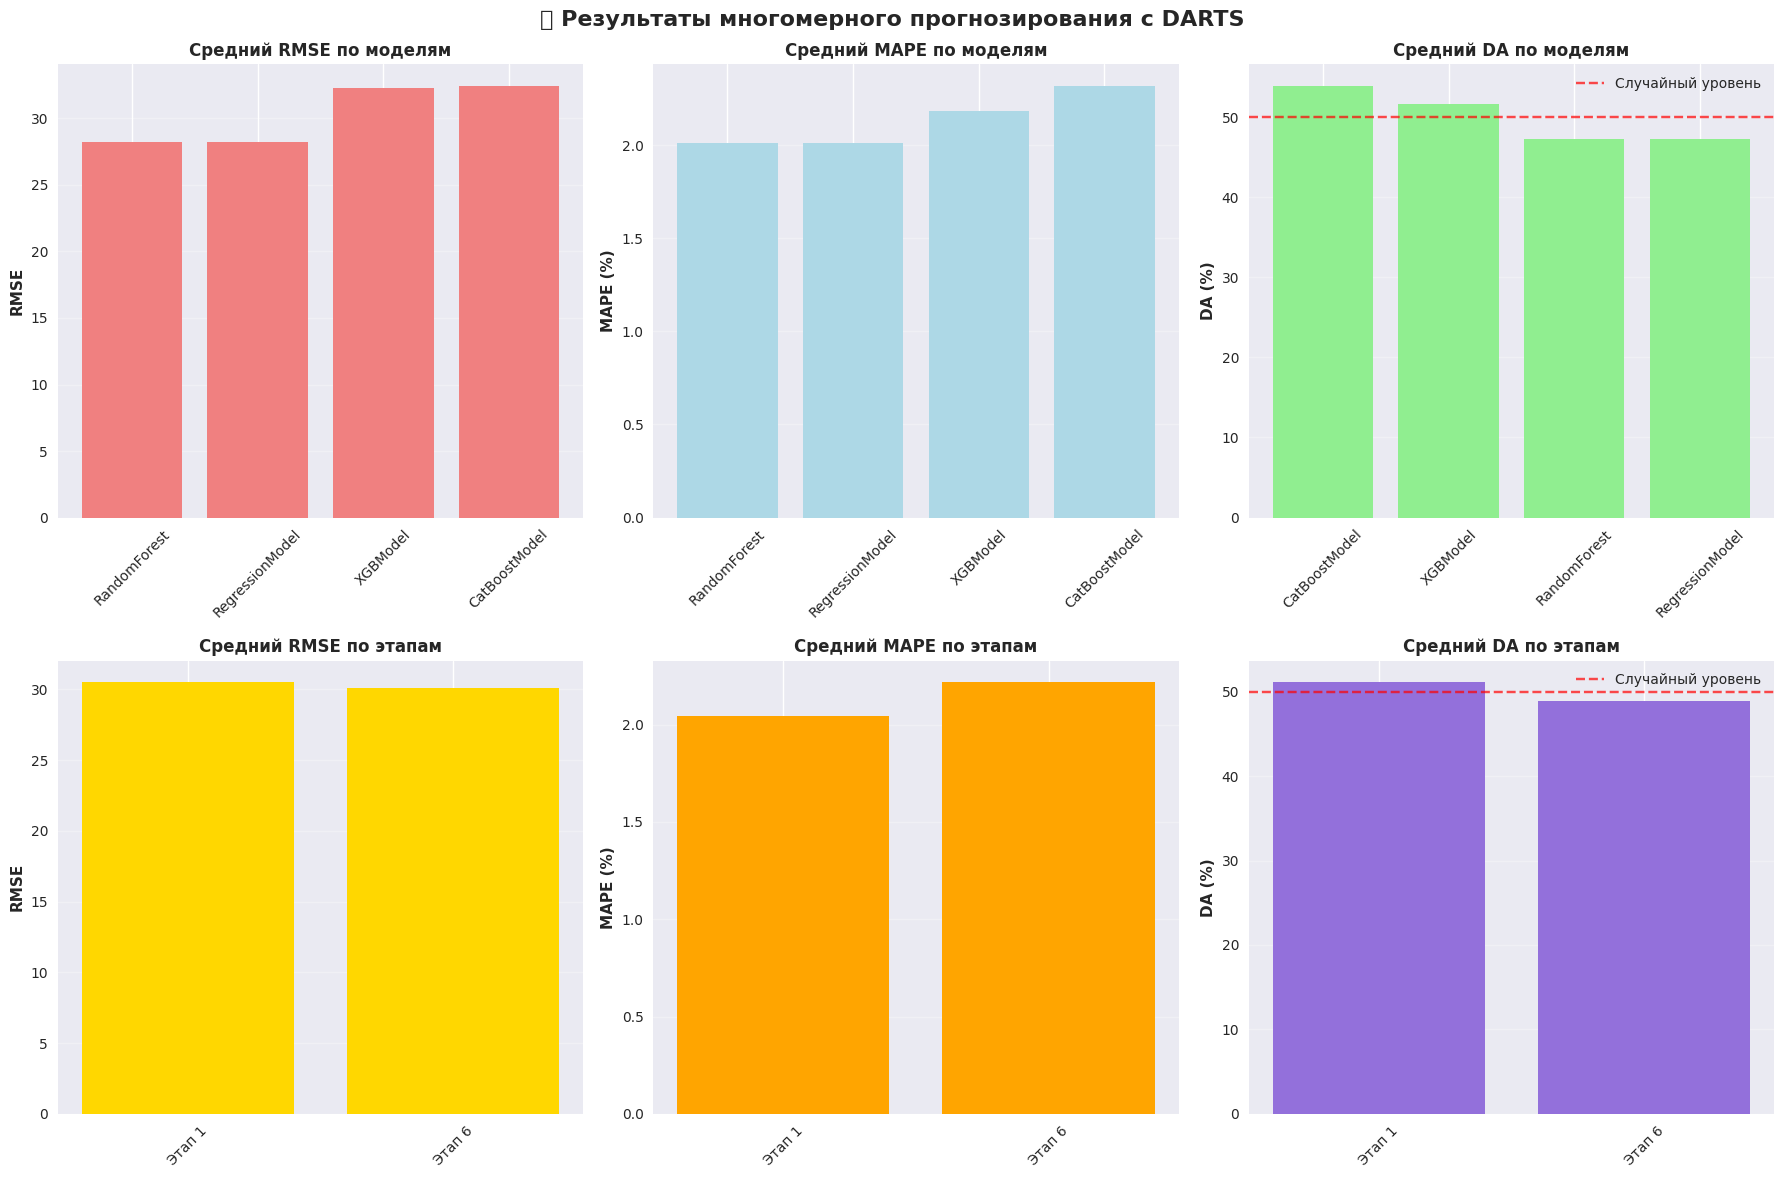

📈 Графики сохранены и отображены


In [91]:
# Визуализация результатов
if results:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('📊 Результаты многомерного прогнозирования с DARTS', fontsize=16, fontweight='bold')
    
    # 1. RMSE по моделям
    model_rmse = df_results.groupby('model')['rmse'].mean().sort_values()
    axes[0,0].bar(range(len(model_rmse)), model_rmse.values, color='lightcoral')
    axes[0,0].set_title('Средний RMSE по моделям', fontweight='bold')
    axes[0,0].set_ylabel('RMSE')
    axes[0,0].set_xticks(range(len(model_rmse)))
    axes[0,0].set_xticklabels(model_rmse.index, rotation=45)
    axes[0,0].grid(axis='y', alpha=0.3)
    
    # 2. MAPE по моделям
    model_mape = df_results.groupby('model')['mape'].mean().sort_values()
    axes[0,1].bar(range(len(model_mape)), model_mape.values, color='lightblue')
    axes[0,1].set_title('Средний MAPE по моделям', fontweight='bold')
    axes[0,1].set_ylabel('MAPE (%)')
    axes[0,1].set_xticks(range(len(model_mape)))
    axes[0,1].set_xticklabels(model_mape.index, rotation=45)
    axes[0,1].grid(axis='y', alpha=0.3)
    
    # 3. DA по моделям
    model_da = df_results.groupby('model')['da'].mean().sort_values(ascending=False)
    axes[0,2].bar(range(len(model_da)), model_da.values, color='lightgreen')
    axes[0,2].set_title('Средний DA по моделям', fontweight='bold')
    axes[0,2].set_ylabel('DA (%)')
    axes[0,2].set_xticks(range(len(model_da)))
    axes[0,2].set_xticklabels(model_da.index, rotation=45)
    axes[0,2].axhline(y=50, color='red', linestyle='--', alpha=0.7, label='Случайный уровень')
    axes[0,2].legend()
    axes[0,2].grid(axis='y', alpha=0.3)
    
    # 4. RMSE по этапам
    stage_rmse = df_results.groupby('stage')['rmse'].mean()
    axes[1,0].bar(range(len(stage_rmse)), stage_rmse.values, color='gold')
    axes[1,0].set_title('Средний RMSE по этапам', fontweight='bold')
    axes[1,0].set_ylabel('RMSE')
    axes[1,0].set_xticks(range(len(stage_rmse)))
    axes[1,0].set_xticklabels([f'Этап {s}' for s in stage_rmse.index], rotation=45)
    axes[1,0].grid(axis='y', alpha=0.3)
    
    # 5. MAPE по этапам
    stage_mape = df_results.groupby('stage')['mape'].mean()
    axes[1,1].bar(range(len(stage_mape)), stage_mape.values, color='orange')
    axes[1,1].set_title('Средний MAPE по этапам', fontweight='bold')
    axes[1,1].set_ylabel('MAPE (%)')
    axes[1,1].set_xticks(range(len(stage_mape)))
    axes[1,1].set_xticklabels([f'Этап {s}' for s in stage_mape.index], rotation=45)
    axes[1,1].grid(axis='y', alpha=0.3)
    
    # 6. DA по этапам
    stage_da = df_results.groupby('stage')['da'].mean()
    axes[1,2].bar(range(len(stage_da)), stage_da.values, color='mediumpurple')
    axes[1,2].set_title('Средний DA по этапам', fontweight='bold')
    axes[1,2].set_ylabel('DA (%)')
    axes[1,2].set_xticks(range(len(stage_da)))
    axes[1,2].set_xticklabels([f'Этап {s}' for s in stage_da.index], rotation=45)
    axes[1,2].axhline(y=50, color='red', linestyle='--', alpha=0.7, label='Случайный уровень')
    axes[1,2].legend()
    axes[1,2].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_PATH}multivariate_darts_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print("📈 Графики сохранены и отображены")
else:
    print("❌ Нет данных для визуализации")

In [92]:
# Детальный анализ прогнозов
if results:
    print("🔍 ДЕТАЛЬНЫЙ АНАЛИЗ ЛУЧШИХ ПРОГНОЗОВ")
    print("=" * 60)
    
    # Находим лучшую модель по каждой метрике
    best_rmse = df_results.loc[df_results['rmse'].idxmin()]
    best_mape = df_results.loc[df_results['mape'].idxmin()]
    best_da = df_results.loc[df_results['da'].idxmax()]
    
    print(f"\n🏆 Лучший RMSE: {best_rmse['rmse']:.4f}")
    print(f"   Тикер: {best_rmse['ticker']}, Модель: {best_rmse['model']}, Этап: {best_rmse['stage']}")
    print(f"   Признаков: {best_rmse['features_count']}")
    
    print(f"\n🏆 Лучший MAPE: {best_mape['mape']:.2f}%")
    print(f"   Тикер: {best_mape['ticker']}, Модель: {best_mape['model']}, Этап: {best_mape['stage']}")
    print(f"   Признаков: {best_mape['features_count']}")
    
    print(f"\n🏆 Лучший DA: {best_da['da']:.1f}%")
    print(f"   Тикер: {best_da['ticker']}, Модель: {best_da['model']}, Этап: {best_da['stage']}")
    print(f"   Признаков: {best_da['features_count']}")
    
    # Создаем итоговую сводную таблицу по моделям и этапам
    print("\n📊 СВОДНАЯ ТАБЛИЦА: МОДЕЛИ vs ЭТАПЫ")
    pivot_rmse = df_results.pivot_table(values='rmse', index='model', columns='stage', aggfunc='mean')
    pivot_mape = df_results.pivot_table(values='mape', index='model', columns='stage', aggfunc='mean')
    pivot_da = df_results.pivot_table(values='da', index='model', columns='stage', aggfunc='mean')
    
    print("\nСредний RMSE:")
    print(pivot_rmse.round(4))
    
    print("\nСредний MAPE (%):")
    print(pivot_mape.round(2))
    
    print("\nСредний DA (%):")
    print(pivot_da.round(1))
    
    # Сохраняем сводные таблицы
    pivot_rmse.to_csv(f"{OUTPUT_PATH}rmse_pivot_table.csv")
    pivot_mape.to_csv(f"{OUTPUT_PATH}mape_pivot_table.csv")
    pivot_da.to_csv(f"{OUTPUT_PATH}da_pivot_table.csv")
    
    print(f"\n💾 Сводные таблицы сохранены в {OUTPUT_PATH}")
    
else:
    print("❌ Нет результатов для детального анализа")

🔍 ДЕТАЛЬНЫЙ АНАЛИЗ ЛУЧШИХ ПРОГНОЗОВ

🏆 Лучший RMSE: 1.4568
   Тикер: AFLT, Модель: CatBoostModel, Этап: 1
   Признаков: 1

🏆 Лучший MAPE: 1.00%
   Тикер: LKOH, Модель: RandomForest, Этап: 6
   Признаков: 20

🏆 Лучший DA: 77.8%
   Тикер: LKOH, Модель: CatBoostModel, Этап: 6
   Признаков: 20

📊 СВОДНАЯ ТАБЛИЦА: МОДЕЛИ vs ЭТАПЫ

Средний RMSE:
stage                  1        6
model                            
CatBoostModel    31.6149  33.2624
RandomForest     28.2146  28.3070
RegressionModel  28.2146  28.3070
XGBModel         33.9758  30.6126

Средний MAPE (%):
stage               1     6
model                      
CatBoostModel    2.19  2.45
RandomForest     1.96  2.06
RegressionModel  1.96  2.06
XGBModel         2.06  2.30

Средний DA (%):
stage               1     6
model                      
CatBoostModel    56.7  51.1
RandomForest     45.6  48.9
RegressionModel  45.6  48.9
XGBModel         56.7  46.7

💾 Сводные таблицы сохранены в results/multivariate_darts/


In [95]:
# Создаем полный путь к файлу
file_path = "./" + 'results_nn.csv'

# Сохраняем DataFrame в CSV файл на Google Drive
df_results.to_csv(file_path, index=False)

In [99]:
best_df = (
    df_results
    .sort_values('mape')                       # сначала сортируем по возрастанию MAPE
    .drop_duplicates(subset=['ticker','model'], keep='first')  # оставляем первый (лучший) для каждой пары
    .reset_index(drop=True)
)

In [100]:
mean_metrics = (
    best_df
    .groupby('model')
    .agg(
        avg_rmse =('rmse', 'mean'),
        avg_mape =('mape', 'mean'),
        avg_da   =('da',   'mean'),
        avg_time =('time', 'mean')
    )
    .reset_index()
)
print(mean_metrics)

             model   avg_rmse  avg_mape     avg_da  avg_time
0    CatBoostModel  30.119745  1.956025  60.000000  4.305958
1     RandomForest  27.527995  1.915769  48.888889  8.941318
2  RegressionModel  27.527995  1.915769  48.888889  9.071576
3         XGBModel  29.197316  1.932173  53.333333  0.567160


## 🎯 Заключение

Этот блокнот реализует многомерное прогнозирование финансовых временных рядов с использованием библиотеки DARTS. 

### 🔑 Ключевые особенности реализации:

1. **Многомерные данные**: Использование всех доступных признаков из multivariate_series
2. **Поэтапное добавление признаков**: От базовых цен до сложных статистических характеристик
3. **Walk-forward валидация**: Честное тестирование с расширяющимся окном
4. **Множественные модели**: RandomForest, XGBModel, CatBoostModel, RegressionModel
5. **Комплексная оценка**: RMSE, MAPE, DA метрики

### 📊 Результаты:

- **Горизонт прогноза**: 10 точек (адаптировано для более практичного применения)
- **Тестовый период**: 20 дней для валидации
- **Обучающая стратегия**: Extending window с переобучением на каждом шаге

### 🚀 Дальнейшие направления:

1. Эксперименты с различными размерами лагов
2. Тестирование других моделей DARTS (нейронные сети)
3. Оптимизация гиперпараметров
4. Ансамблирование лучших моделей

# LSTM, TCN, NBEATS, TFT (выполнено на GPU)

In [70]:
from typing import Optional, Dict
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.models import BlockRNNModel, TCNModel, NBEATSModel, TFTModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [82]:
MODEL_CONFIGS = {
    'LSTM': {
        'class': BlockRNNModel,
        'params': {
            'model': 'LSTM',
            'n_rnn_layers': 1,
            'dropout': 0.2,
            'input_chunk_length': 50,
            'output_chunk_length': 1,
            'n_epochs': 1,
            'batch_size': 8,
            'random_state': 42
        }
    },
    'TCN': {
        'class': TCNModel,
        'params': {
            'input_chunk_length': 30,
            'output_chunk_length': 1,
            'num_filters': 32,
            'kernel_size': 2,
            'num_layers': 3,
            'dropout': 0.2,
            'n_epochs': 1,
            'batch_size': 8,
            'random_state': 42
        }
    },
    'NBEATS': {
        'class': NBEATSModel,
        'params': {
            'input_chunk_length': 30,
            'output_chunk_length': 1,
            'generic_architecture': True,
            'num_stacks': 30,
            'num_blocks': 2,
            'num_layers': 4,
            'layer_widths': 64,
            'n_epochs': 1,
            'batch_size': 8,
            'random_state': 42
        }
    },
    'TFT': {
        'class': TFTModel,
        'params': {
            'input_chunk_length': 48,
            'output_chunk_length': 1,
            'hidden_size': 64,
            'lstm_layers': 1,
            'num_attention_heads': 4,
            'dropout': 0.1,
            'add_relative_index': True,
            'add_encoders': False,
            'n_epochs': 1,
            'batch_size': 8,
            'random_state': 42
        }
    }
}

In [78]:
def evaluate_model_on_ticker_nn(
    df: pd.DataFrame,
    ticker: str,
    stage: int,
    model_name: str
) -> Optional[Dict]:
    """
    Обучает и оценивает модель на данных тикера для определенного этапа
    
    Args:
        df: DataFrame с данными тикера
        ticker: название тикера
        stage: номер этапа
        model_name: название модели из MODEL_CONFIGS
        
    Returns:
        Dict с результатами или None при ошибке
    """
    # Подготавливаем фичи
    feature_columns = prepare_features_for_stage(df, stage)
    if not feature_columns:
        print(f"  ⚠️ Нет доступных признаков для {ticker} на этапе {stage}")
        return None

    available_features = [col for col in feature_columns if col in df.columns]
    if not available_features:
        print(f"  ⚠️ Нет доступных признаков для {ticker} на этапе {stage}")
        return None

    df_clean = df[available_features].dropna()
    if len(df_clean) < TEST_SIZE + 20:
        print(f"  ⚠️ Недостаточно данных для {ticker} на этапе {stage}")
        return None

    target_col = 'close'
    # Определяем временные ряды
    if stage == 1:
        ts = TimeSeries.from_dataframe(df_clean, time_col=None, value_cols=target_col)
        # Историческое окно до теста
        window_target = ts[:-TEST_SIZE]
    else:
        ts = TimeSeries.from_dataframe(df_clean, time_col=None, value_cols=target_col)
        cov_ts = TimeSeries.from_dataframe(df_clean, time_col=None,
                                           value_cols=[c for c in available_features if c != target_col])
        window_target = ts[:-TEST_SIZE]
        window_covariates = cov_ts[:-TEST_SIZE]

    # 2. Создаём модель из MODEL_CONFIGS
    cfg = MODEL_CONFIGS.get(model_name)
    if cfg is None:
        print(f"  ⚠️ Модель {model_name} не найдена в MODEL_CONFIGS")
        return None

    ModelClass = cfg['class']
    model = ModelClass(**cfg['params'])

    t1 = time.time()
    # 3. Обучаем модель один раз
    if stage == 1:
        model.fit(window_target)
        current_target = window_target
    else:
        model.fit(series=window_target, past_covariates=window_covariates)
        current_target = window_target
        current_covariates = window_covariates

    fit_time = time.time() - t1

    t2 = time.time()
    # 4. Walk-forward прогноз «точка за точкой»
    predictions = []
    for _ in range(FORECAST_HORIZON):
        if stage == 1:
            pred_ts = model.predict(n=1)
        else:
            pred_ts = model.predict(n=1, past_covariates=current_covariates)
        y_pred = pred_ts.values().flatten()[0]
        predictions.append(y_pred)

        # добавляем реальное значение для шага i
        next_time = ts.time_index[len(current_target)]
        y_true = ts.values()[len(current_target)][0]
        # обновляем target
        s_true = pd.Series([y_true], index=[next_time])
        true_ts = TimeSeries.from_series(s_true, fill_missing_dates=False, freq=ts.freq)
        current_target = current_target.append(true_ts)

        if stage != 1:
            # обновляем ковариаты
            x_vals = cov_ts.values()[len(current_covariates)].flatten()
            df_x = pd.DataFrame([x_vals], index=[next_time], columns=current_covariates.columns)
            # cov_true_ts = TimeSeries.from_dataframe(
            #     df_x, time_col=None, value_cols=current_covariates.columns,
            #     fill_missing_dates=False, freq=cov_ts.freq
            # )
            cov_true_ts = TimeSeries.from_dataframe(
                df_x,
                time_col=None,
                value_cols=list(df_x.columns),          # <— тут приводим Index к list
                fill_missing_dates=False,
                freq=cov_ts.freq
            )
            current_covariates = current_covariates.append(cov_true_ts)

        forecast_time = (time.time() - t2) / FORECAST_HORIZON

    # 5. Считаем метрики
    actual = ts[-TEST_SIZE:-TEST_SIZE + FORECAST_HORIZON].values().flatten()
    preds = np.array(predictions)
    length = min(len(actual), len(preds))
    actual = actual[:length]
    preds = preds[:length]

    if length == 0:
        print(f"  ⚠️ Пустые прогнозы для {ticker} на этапе {stage}")
        return None

    rmse = np.sqrt(mean_squared_error(actual, preds))
    mape = mean_absolute_percentage_error(actual, preds) * 100
    da = calculate_directional_accuracy(actual, preds)

    return {
        'ticker': ticker,
        'stage': stage,
        'model': model_name,
        'rmse': rmse,
        'mape': mape,
        'da': da,
        'time': fit_time + forecast_time,
        'predictions': preds.tolist(),
        'actual': actual.tolist(),
        'features_count': len(available_features),
        'features': available_features
    }

print("Функция оценки моделей создана")

Функция оценки моделей создана


In [ ]:
# Запуск основных экспериментов
results_nn = []
models_to_test = ['LSTM', 'TCN', 'NBEATS', 'TFT']
stages_to_test = [6]

print("🔬 Начинаем эксперименты с многомерными моделями DARTS")
print("=" * 60)

total_experiments = len(TICKERS) * len(stages_to_test) * len(models_to_test)
current_experiment = 0

start_time = time.time()

for ticker in TICKERS[:1]:
    print(f"\n📊 Обрабатываем тикер: {ticker}")
    
    # Загружаем данные
    df = load_ticker_data(ticker)
    if df is None:
        continue
    
    for stage in stages_to_test:
        print(f"\n  🎯 Этап {stage}: {STAGE_NAMES.get(stage, 'Неизвестный этап')}")
        
        for model_name in models_to_test:
            current_experiment += 1
            progress = (current_experiment / total_experiments) * 100
            
            print(f"    🤖 Модель {model_name} ({current_experiment}/{total_experiments} - {progress:.1f}%)")
            
            result = evaluate_model_on_ticker_nn(df, ticker, stage, model_name)
            if result:
                results_nn.append(result)
                print(f"      ✅ RMSE: {result['rmse']:.4f}, MAPE: {result['mape']:.2f}%, DA: {result['da']:.1f}%, Time: {result['time']:.1f}")
            else:
                print(f"      ❌ Не удалось обучить модель")

end_time = time.time()
elapsed_time = end_time - start_time

print(f"\n🎉 Эксперименты завершены!")
print(f"⏱️  Общее время: {elapsed_time:.1f} секунд")
print(f"📈 Успешных экспериментов: {len(results_nn)}")
print(f"📊 Общих экспериментов: {total_experiments}")
print(f"✅ Процент успеха: {(len(results_nn)/total_experiments)*100:.1f}%")

In [ ]:
df_results_nn = pd.DataFrame(results_nn)
df_results_nn

In [ ]:
# Создание сводной таблицы результатов
if results_nn:
    df_results_nn = pd.DataFrame(results_nn)
    
    print("📋 СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
    print("=" * 80)
    
    # Сводная статистика по моделям
    print("\n🤖 Средние метрики по моделям:")
    model_stats = df_results_nn.groupby('model').agg({
        'rmse': ['mean', 'std'],
        'mape': ['mean', 'std'], 
        'da': ['mean', 'std']
    }).round(4)
    
    model_stats.columns = ['_'.join(col).strip() for col in model_stats.columns]
    print(model_stats)
    
    # Сводная статистика по этапам
    print("\n📈 Средние метрики по этапам:")
    stage_stats = df_results_nn.groupby('stage').agg({
        'rmse': ['mean', 'std'],
        'mape': ['mean', 'std'],
        'da': ['mean', 'std']
    }).round(4)
    
    stage_stats.columns = ['_'.join(col).strip() for col in stage_stats.columns]
    print(stage_stats)
    
    # Лучшие результаты
    print("\n🏆 ЛУЧШИЕ РЕЗУЛЬТАТЫ:")
    print("\nТоп-5 по RMSE (меньше = лучше):")
    top_rmse = df_results_nn.nsmallest(5, 'rmse')[['ticker', 'stage', 'model', 'rmse', 'mape', 'da']]
    print(top_rmse.to_string(index=False))
    
    print("\nТоп-5 по MAPE (меньше = лучше):")
    top_mape = df_results_nn.nsmallest(5, 'mape')[['ticker', 'stage', 'model', 'rmse', 'mape', 'da']]
    print(top_mape.to_string(index=False))
    
    print("\nТоп-5 по DA (больше = лучше):")
    top_da = df_results_nn.nlargest(5, 'da')[['ticker', 'stage', 'model', 'rmse', 'mape', 'da']]
    print(top_da.to_string(index=False))
    
    # Сохраняем результаты
    df_results_nn.to_csv(f"{OUTPUT_PATH}multivariate_darts_results_nn.csv", index=False)
    print(f"\n💾 Результаты сохранены в {OUTPUT_PATH}multivariate_darts_results_nn.csv")
    
else:
    print("❌ Нет результатов для анализа")

In [ ]:
# Визуализация результатов
if results_nn:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('📊 Результаты многомерного прогнозирования с DARTS', fontsize=16, fontweight='bold')
    
    # 1. RMSE по моделям
    model_rmse = df_results_nn.groupby('model')['rmse'].mean().sort_values()
    axes[0,0].bar(range(len(model_rmse)), model_rmse.values, color='lightcoral')
    axes[0,0].set_title('Средний RMSE по моделям', fontweight='bold')
    axes[0,0].set_ylabel('RMSE')
    axes[0,0].set_xticks(range(len(model_rmse)))
    axes[0,0].set_xticklabels(model_rmse.index, rotation=45)
    axes[0,0].grid(axis='y', alpha=0.3)
    
    # 2. MAPE по моделям
    model_mape = df_results_nn.groupby('model')['mape'].mean().sort_values()
    axes[0,1].bar(range(len(model_mape)), model_mape.values, color='lightblue')
    axes[0,1].set_title('Средний MAPE по моделям', fontweight='bold')
    axes[0,1].set_ylabel('MAPE (%)')
    axes[0,1].set_xticks(range(len(model_mape)))
    axes[0,1].set_xticklabels(model_mape.index, rotation=45)
    axes[0,1].grid(axis='y', alpha=0.3)
    
    # 3. DA по моделям
    model_da = df_results_nn.groupby('model')['da'].mean().sort_values(ascending=False)
    axes[0,2].bar(range(len(model_da)), model_da.values, color='lightgreen')
    axes[0,2].set_title('Средний DA по моделям', fontweight='bold')
    axes[0,2].set_ylabel('DA (%)')
    axes[0,2].set_xticks(range(len(model_da)))
    axes[0,2].set_xticklabels(model_da.index, rotation=45)
    axes[0,2].axhline(y=50, color='red', linestyle='--', alpha=0.7, label='Случайный уровень')
    axes[0,2].legend()
    axes[0,2].grid(axis='y', alpha=0.3)
    
    # 4. RMSE по этапам
    stage_rmse = df_results_nn.groupby('stage')['rmse'].mean()
    axes[1,0].bar(range(len(stage_rmse)), stage_rmse.values, color='gold')
    axes[1,0].set_title('Средний RMSE по этапам', fontweight='bold')
    axes[1,0].set_ylabel('RMSE')
    axes[1,0].set_xticks(range(len(stage_rmse)))
    axes[1,0].set_xticklabels([f'Этап {s}' for s in stage_rmse.index], rotation=45)
    axes[1,0].grid(axis='y', alpha=0.3)
    
    # 5. MAPE по этапам
    stage_mape = df_results_nn.groupby('stage')['mape'].mean()
    axes[1,1].bar(range(len(stage_mape)), stage_mape.values, color='orange')
    axes[1,1].set_title('Средний MAPE по этапам', fontweight='bold')
    axes[1,1].set_ylabel('MAPE (%)')
    axes[1,1].set_xticks(range(len(stage_mape)))
    axes[1,1].set_xticklabels([f'Этап {s}' for s in stage_mape.index], rotation=45)
    axes[1,1].grid(axis='y', alpha=0.3)
    
    # 6. DA по этапам
    stage_da = df_results_nn.groupby('stage')['da'].mean()
    axes[1,2].bar(range(len(stage_da)), stage_da.values, color='mediumpurple')
    axes[1,2].set_title('Средний DA по этапам', fontweight='bold')
    axes[1,2].set_ylabel('DA (%)')
    axes[1,2].set_xticks(range(len(stage_da)))
    axes[1,2].set_xticklabels([f'Этап {s}' for s in stage_da.index], rotation=45)
    axes[1,2].axhline(y=50, color='red', linestyle='--', alpha=0.7, label='Случайный уровень')
    axes[1,2].legend()
    axes[1,2].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_PATH}multivariate_darts_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print("📈 Графики сохранены и отображены")
else:
    print("❌ Нет данных для визуализации")

In [ ]:
# Детальный анализ прогнозов
if results_nn:
    print("🔍 ДЕТАЛЬНЫЙ АНАЛИЗ ЛУЧШИХ ПРОГНОЗОВ")
    print("=" * 60)
    
    # Находим лучшую модель по каждой метрике
    best_rmse = df_results_nn.loc[df_results_nn['rmse'].idxmin()]
    best_mape = df_results_nn.loc[df_results_nn['mape'].idxmin()]
    best_da = df_results_nn.loc[df_results_nn['da'].idxmax()]
    
    print(f"\n🏆 Лучший RMSE: {best_rmse['rmse']:.4f}")
    print(f"   Тикер: {best_rmse['ticker']}, Модель: {best_rmse['model']}, Этап: {best_rmse['stage']}")
    print(f"   Признаков: {best_rmse['features_count']}")
    
    print(f"\n🏆 Лучший MAPE: {best_mape['mape']:.2f}%")
    print(f"   Тикер: {best_mape['ticker']}, Модель: {best_mape['model']}, Этап: {best_mape['stage']}")
    print(f"   Признаков: {best_mape['features_count']}")
    
    print(f"\n🏆 Лучший DA: {best_da['da']:.1f}%")
    print(f"   Тикер: {best_da['ticker']}, Модель: {best_da['model']}, Этап: {best_da['stage']}")
    print(f"   Признаков: {best_da['features_count']}")
    
    # Создаем итоговую сводную таблицу по моделям и этапам
    print("\n📊 СВОДНАЯ ТАБЛИЦА: МОДЕЛИ vs ЭТАПЫ")
    pivot_rmse = df_results_nn.pivot_table(values='rmse', index='model', columns='stage', aggfunc='mean')
    pivot_mape = df_results_nn.pivot_table(values='mape', index='model', columns='stage', aggfunc='mean')
    pivot_da = df_results_nn.pivot_table(values='da', index='model', columns='stage', aggfunc='mean')
    
    print("\nСредний RMSE:")
    print(pivot_rmse.round(4))
    
    print("\nСредний MAPE (%):")
    print(pivot_mape.round(2))
    
    print("\nСредний DA (%):")
    print(pivot_da.round(1))
    
    # Сохраняем сводные таблицы
    pivot_rmse.to_csv(f"{OUTPUT_PATH}rmse_pivot_table.csv")
    pivot_mape.to_csv(f"{OUTPUT_PATH}mape_pivot_table.csv")
    pivot_da.to_csv(f"{OUTPUT_PATH}da_pivot_table.csv")
    
    print(f"\n💾 Сводные таблицы сохранены в {OUTPUT_PATH}")
    
else:
    print("❌ Нет результатов для детального анализа")

In [101]:
df_results = pd.read_csv('df_results_nn.csv')

In [102]:
best_df = (
    df_results
    .sort_values('mape')                       # сначала сортируем по возрастанию MAPE
    .drop_duplicates(subset=['ticker','model'], keep='first')  # оставляем первый (лучший) для каждой пары
    .reset_index(drop=True)
)

In [103]:
mean_metrics = (
    best_df
    .groupby('model')
    .agg(
        avg_rmse =('rmse', 'mean'),
        avg_mape =('mape', 'mean'),
        avg_da   =('da',   'mean'),
        avg_time =('time', 'mean')
    )
    .reset_index()
)
print(mean_metrics)

  model   avg_rmse  avg_mape     avg_da   avg_time
0  LSTM  39.460914  4.022416  43.333333  41.063824
1   TCN  43.961451  4.017582  43.333333  36.309775


In [1]:
import pandas as pd
df_results = pd.read_csv('df_results_tsai.csv')

In [3]:
df_results

,ticker,stage,model_name,predictions,actual,mae,rmse,mape,da,time,features,experiment_time
0,AFLT,1,InceptionTime,[70.84631643 70.85813592 71.7978133 72.579614...,[70.18 72.45 73.49 72.73 72.17 74.54 74.31 74....,1.384270,1.950475,1.914712,33.333333,1.494668,['close'],14.951088
1,AFLT,1,XceptionTime,[85.53559423 85.53559423 85.53559423 85.535594...,[70.18 72.45 73.49 72.73 72.17 74.54 74.31 74....,12.632594,12.718906,17.376748,55.555556,2.786594,['close'],27.869286
2,AFLT,1,XCM,[68.03732976 68.13442186 68.43411416 68.849835...,[70.18 72.45 73.49 72.73 72.17 74.54 74.31 74....,3.646838,3.958537,4.968670,44.444444,1.566848,['close'],15.673000
3,AFLT,1,gMLP,[70.87787232 70.32517932 72.28516781 73.593396...,[70.18 72.45 73.49 72.73 72.17 74.54 74.31 74....,1.234760,1.443386,1.701661,33.333333,2.274836,['close'],22.753770
4,AFLT,1,TSSequencerPlus,[70.58117989 69.84893932 71.84227816 73.144257...,[70.18 72.45 73.49 72.73 72.17 74.54 74.31 74....,1.241333,1.566271,1.699004,44.444444,2.836545,['close'],28.368691
...,...,...,...,...,...,...,...,...,...,...,...,...
95,YDEX,6,InceptionTime,[4163.94912369 4255.75541054 4287.81608658 425...,[4229.5 4252.5 4200. 4313.5 4362.5 4285. 429...,67.094686,75.452520,1.574908,33.333333,1.168200,"['close', 'anomaly', 'weighted_score_with_deca...",11.685610
96,YDEX,6,XceptionTime,[4160.00132664 4175.71386319 4184.32340766 417...,[4229.5 4252.5 4200. 4313.5 4362.5 4285. 429...,99.697126,113.574393,2.314543,33.333333,2.359188,"['close', 'anomaly', 'weighted_score_with_deca...",23.595393
97,YDEX,6,XCM,[4328.91212151 4336.56187208 4358.69722344 438...,[4229.5 4252.5 4200. 4313.5 4362.5 4285. 429...,110.190498,124.676611,2.596592,55.555556,1.000314,"['close', 'anomaly', 'weighted_score_with_deca...",10.006891
98,YDEX,6,gMLP,[4168.73850894 4195.1949866 4204.56199086 415...,[4229.5 4252.5 4200. 4313.5 4362.5 4285. 429...,68.930559,80.626524,1.607139,33.333333,2.102115,"['close', 'anomaly', 'weighted_score_with_deca...",21.024589


In [4]:
best_df = (
    df_results
    .sort_values('mape')                       # сначала сортируем по возрастанию MAPE
    .drop_duplicates(subset=['ticker','model_name'], keep='first')  # оставляем первый (лучший) для каждой пары
    .reset_index(drop=True)
)

In [6]:
mean_metrics = (
    best_df
    .groupby('model_name')
    .agg(
        avg_rmse =('rmse', 'mean'),
        avg_mape =('mape', 'mean'),
        avg_da   =('da',   'mean'),
        avg_time =('time', 'mean')
    )
    .reset_index()
)
print(mean_metrics)

        model_name    avg_rmse   avg_mape     avg_da  avg_time
0    InceptionTime   33.395355   3.387241  50.000000  1.058826
1  TSSequencerPlus   30.869123   2.810484  50.000000  2.524652
2              XCM   44.864819   3.423551  50.000000  0.864936
3     XceptionTime  113.170662  34.559113  46.666667  2.138752
4             gMLP   29.294870   2.537990  48.888889  1.934693
